In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
import matplotlib.pyplot as plt
from sklearn import *
import math 
import random
import itertools

In [2]:
# data
d=5
L=2000


eta_X=datasets.make_spd_matrix(d, random_state=None)
eta_N=datasets.make_spd_matrix(d, random_state=None)   
eta_Y=eta_X+eta_N

meu=np.zeros(d)


def gen_X():
    return np.random.multivariate_normal( mean=meu,
                                  cov=eta_X,
                                  size = L)
def noise():
    return np.random.multivariate_normal( mean=meu,
                                  cov=eta_N,
                                 size = L)

def gen_Y(X,N):
    return X+N



In [19]:
X=gen_X()
N=noise()
y=gen_Y(X,N)
    
mi = 0.5*math.log(np.linalg.det(eta_Y)/np.linalg.det(eta_X),2)
print(mi)

[0 7 8 6 9 5 3 4 1 2]
3.2308617186339594


In [4]:
def ma(array, policy,window_size=None, beta=None):
    x=np.zeros(len(array))
    if policy=='window':
        for i in range(0, len(array)):
            if i<window_size:
                x[i]= np.mean(array[0: i])
            else:
                x[i]= np.mean(array[i-window_size: i])
    elif policy=='weighted':
        x[0]=array[0]
        for i in range(1, len(array)):
               x[i]=x[i-1]*(1-beta)+beta*array[i]
    elif policy=='None':
        for i in range(1, len(array)):
             x[i]=array[i] 
    return x


In [86]:
I=20
H=40
O=100
n_epochs = 200

def MINE(x_in, y_in):
    
    In=tf.concat([x_in, y_in], axis=1)
    In=tf.reshape(In, [-1,1])

    # propagate the forward pass
    layerIn = tf.contrib.layers.fully_connected(In, I,weights_initializer=layers.xavier_initializer(), activation_fn=tf.nn.sigmoid)
    layer1 = tf.contrib.layers.fully_connected(layerIn, H,weights_initializer=layers.xavier_initializer(), activation_fn=tf.nn.sigmoid)
    layer2 = tf.contrib.layers.fully_connected(layer1, O,weights_initializer=layers.xavier_initializer(), activation_fn=tf.nn.sigmoid)
    output = tf.contrib.layers.fully_connected(layer2, 1,weights_initializer=layers.xavier_initializer(), activation_fn=tf.nn.relu)
    
    # split in T_xy and T_x_y predictions
    N_samples = L
    T_xy = output[N_samples:]
    T_x_y = output[:N_samples]
    # compute the negative loss (maximise loss == minimise -loss)
    neg_loss = -(tf.reduce_mean(T_xy, axis=0) - tf.math.log(tf.reduce_mean(tf.math.exp(T_x_y))+10e-4)/tf.math.log(2.0))
    opt = tf.train.AdamOptimizer(learning_rate=0.01).minimize(neg_loss)
    t=[T_xy[-1], T_x_y[-1]]
    return neg_loss, opt,t


In [93]:
# prepare the placeholders for inputs
x_in = tf.placeholder(tf.float32, [L, d], name='x_in')
y_in = tf.placeholder(tf.float32, [L, d], name='y_in')
# make the loss and optimisation graphs
neg_loss, opt,t = MINE(x_in, y_in)

# start the session
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# train
MIs = []


for epoch in range(n_epochs):
    
    # generate the data
    x_sample=gen_X()
    noise_sample=noise()
    Y=gen_Y(x_sample,noise_sample)
    
    x_shuffle=x_sample
    y_shuffle=Y
    np.random.shuffle(x_shuffle)
    np.random.shuffle(y_shuffle)

    # perform the training step 
    _, neg_l , te = sess.run([opt, neg_loss,t], feed_dict={x_in:x_sample, y_in:Y})
    _, neg_l , te = sess.run([opt, neg_loss,t], feed_dict={x_in:x_shuffle, y_in:y_shuffle})
    print (te)
    # save the loss
    MIs.append(-neg_l)
    print(epoch/n_epochs*100,end='\r')
mv_av=ma(MIs, policy='None', window_size=10)




[array([-0.], dtype=float32), array([-0.], dtype=float32)]
[array([-0.], dtype=float32), array([-0.], dtype=float32)]
[array([-0.], dtype=float32), array([-0.], dtype=float32)]
[array([-0.], dtype=float32), array([-0.], dtype=float32)]
[array([-0.], dtype=float32), array([-0.], dtype=float32)]
[array([-0.], dtype=float32), array([-0.], dtype=float32)]
[array([-0.], dtype=float32), array([-0.], dtype=float32)]
[array([-0.], dtype=float32), array([-0.], dtype=float32)]
[array([-0.], dtype=float32), array([-0.], dtype=float32)]
[array([-0.], dtype=float32), array([-0.], dtype=float32)]
[array([-0.], dtype=float32), array([-0.], dtype=float32)]
[array([-0.], dtype=float32), array([-0.], dtype=float32)]
[array([-0.], dtype=float32), array([-0.], dtype=float32)]
[array([-0.], dtype=float32), array([-0.], dtype=float32)]
[array([-0.], dtype=float32), array([-0.], dtype=float32)]
[array([-0.], dtype=float32), array([-0.], dtype=float32)]
[array([-0.], dtype=float32), array([-0.], dtype=float32

[array([-0.], dtype=float32), array([-0.], dtype=float32)]
[array([-0.], dtype=float32), array([-0.], dtype=float32)]
[array([-0.], dtype=float32), array([-0.], dtype=float32)]
[array([-0.], dtype=float32), array([-0.], dtype=float32)]
[array([-0.], dtype=float32), array([-0.], dtype=float32)]
[array([-0.], dtype=float32), array([-0.], dtype=float32)]
[array([-0.], dtype=float32), array([-0.], dtype=float32)]
[array([-0.], dtype=float32), array([-0.], dtype=float32)]
[array([-0.], dtype=float32), array([-0.], dtype=float32)]
[array([-0.], dtype=float32), array([-0.], dtype=float32)]
[array([-0.], dtype=float32), array([-0.], dtype=float32)]
[array([-0.], dtype=float32), array([-0.], dtype=float32)]
[array([-0.], dtype=float32), array([-0.], dtype=float32)]
[array([-0.], dtype=float32), array([-0.], dtype=float32)]
[array([-0.], dtype=float32), array([-0.], dtype=float32)]
[array([-0.], dtype=float32), array([-0.], dtype=float32)]
[array([-0.], dtype=float32), array([-0.], dtype=float32

true value:
3.2308617186339594
calculated value:
[-0.00144204]
error
100.04463333953902




C:\Users\ahmedadel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


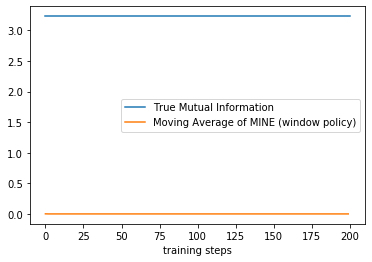

In [83]:
fig, ax = plt.subplots()
ax.plot([0, len(MIs)], [mi,mi], label='True Mutual Information')
ax.plot(range(len(mv_av)), mv_av, label='Moving Average of MINE (window policy)')

ax.set_xlabel('training steps')
ax.legend(loc='best')
fig.savefig('MINE_window.png')
fig.show()



error=(abs(mv_av[-1]-mi)/mi)*100
print('true value:')
print(mi)
print('calculated value:')
print(MIs[-1])
print('error')
print(error)
print('\n')